In [ ]:
import pvdeg

import xarray as xr
import pandas as pd
import inspire_agrivolt
from dask.distributed import LocalCluster, Client
import glob
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

import inspire_agrivolt

In [2]:
workers = 8

cluster = LocalCluster(
    n_workers=workers,
    processes=True,
    dashboard_address=22118,
)

client = Client(cluster)

In [7]:
files = glob.glob("/projects/inspire/PySAM-MAPS/Full-Outputs/Colorado/01/*.nc")
zarr_path = "/projects/inspire/PySAM-MAPS/Full-Outputs/Colorado/01/merged.zarr"

inspire_agrivolt.pysam_output_netcdf_to_zarr(
    files=files,
    zarr_path=zarr_path
)

In [8]:
full_co_01 = xr.open_zarr(zarr_path)

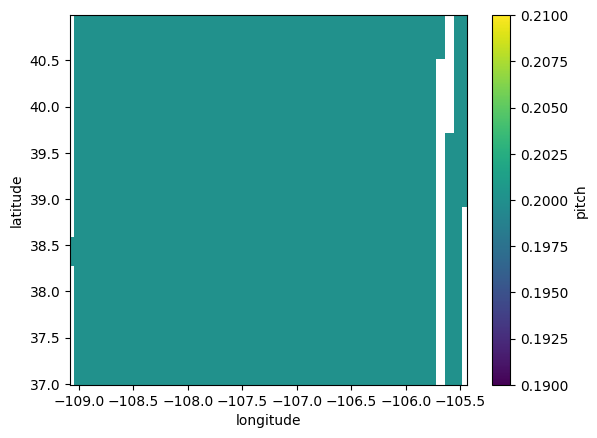

In [14]:
full_co_01.pitch.plot()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def plot_dataset_grids(files: list[str], engine="netcdf4") -> None:
    """
    Plot the (longitude, latitude) grid points from each dataset with different colors.

    Parameters
    ----------
    files : list[str]
        List of NetCDF file paths.
    engine : str
        Backend engine to use for opening NetCDF files.
    """
    cmap = get_cmap("tab20")  # Up to 20 distinguishable colors
    num_colors = len(files)

    plt.figure(figsize=(10, 6))

    for i, file in enumerate(files):
        with xr.open_dataset(file, engine=engine) as ds:
            lats = ds.latitude.values
            lons = ds.longitude.values

            grid_lon, grid_lat = np.meshgrid(lons, lats)

            plt.scatter(
                grid_lon.flatten(),
                grid_lat.flatten(),
                s=3,
                color=cmap(i % 20),
                label=f"File {i}",
                marker='x'
            )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Grid points from each NetCDF file")
    plt.legend(markerscale=3, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_dataset_grids(files)

In [ ]:
xr.open_zarr("/projects/inspire/PySAM-MAPS/Full-Outputs/Colorado/01/merged.zarr")

In [ ]:
WEATHER_DB = "NSRDB"
WEATHER_ARG = {
    "satellite": "Americas",
    "names": "TMY",
    "NREL_HPC": True,
    "attributes": pvdeg.pysam.INSPIRE_NSRDB_ATTRIBUTES,
}

In [ ]:
weather, meta, chunk_size = inspire_agrivolt.load_weather(local_test_paths=None, state="Colorado")

In [ ]:
weather

In [ ]:
pvdeg.geospatial.output_template

In [ ]:
pvdeg.geospatial.output_template(ds_gids=weather, shapes=pvdeg.pysam.INSPIRE_GEOSPATIAL_TEMPLATE_SHAPES, add_dims={"distance":10})

In [ ]:
meta.iloc[12:15].index

In [ ]:
pvdeg.weather.get(
    WEATHER_DB,
    geospatial=True, 
    **WEATHER_ARG
)

In [ ]:
len(meta)

In [ ]:
"wind_direction" in geo_weather.data_vars

In [ ]:
geo_weather = geo_weather.assign(wind_direction=geo_weather["temp_air"] * 0)
geo_weather = geo_weather.assign(albedo=geo_weather["temp_air"] * 0 + 0.2) 

geo_weather

In [ ]:
geo_weather = xr.open_dataset("C:/Users/tford/Downloads/small-usa-tmy.nc")
geo_meta = pd.read_csv("C:/Users/tford/Downloads/small-usa-tmy.csv", index_col=0)

weather_df = geo_weather.isel(gid=0).to_dataframe()
meta = geo_meta.iloc[0].to_dict()

# add placeholder wind and albedo data
# this will come from the NSRDB but this file does not contain it
weather_df["wind_direction"] = 0
weather_df["albedo"] = 0.2

In [ ]:
conf = "01"

single_loc_res = pvdeg.pysam.inspire_ground_irradiance(
    weather_df=weather_df,
    meta=meta,
    config_files={"pv":f"C:/Users/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/{conf}/{conf}_pvsamv1.json"}
)

In [ ]:
# 15 day plot we can see that they all have values
single_loc_res.ground_irradiance.isel(time=slice(650,1000)).plot()